In [7]:
import os
import sys
import pandas as pd
import csv
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [8]:
from xgboost import XGBRegressor,plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import Normalizer
import xgboost as xgb

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [10]:
from matplotlib import pyplot
%matplotlib inline

In [11]:
data_folder = '../data'
data_files = os.listdir(data_folder)

In [12]:
year_2014 = pd.read_csv(data_folder+'/'+data_files[0])
year_2014.head()

,Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,Local Time Zone,...,Wind Direction Units,Wind Speed,Snow Depth Units,Fill Flag 0,Fill Flag 1,Fill Flag 2,Fill Flag 3,Fill Flag 4,Fill Flag 5,Version
0,SUNY,22306,-,-,India,24.65,73.75,5.5,0,5.5,...,Degrees,m/s,m,NaN,Missing Image,Low Irradiance,Exceeds Clearsky,Missing CLoud Properties,Rayleigh Violation,unknown
1,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,1,1,0,30,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,1,1,30,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,1,1,2,30,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
new_columns = year_2014.iloc[1]
year_all = year_2014[2:]
year_all.columns =new_columns
year = year_all.loc[:, year_all.columns.notnull()]

# for counter,i in enumerate(new_columns):
#     print(i)


year = year.drop(columns=['Year','Month','Day','Minute','DHI','DNI','Clearsky DHI','Clearsky DNI','Fill Flag','Dew Point','Clearsky GHI','Solar Zenith Angle','Wind Direction','Snow Depth','Precipitable Water'])

In [14]:
year = year.astype('float64')
year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 2 to 8761
Data columns (total 6 columns):
Hour                 8760 non-null float64
GHI                  8760 non-null float64
Temperature          8760 non-null float64
Pressure             8760 non-null float64
Relative Humidity    8760 non-null float64
Wind Speed           8760 non-null float64
dtypes: float64(6)
memory usage: 410.7 KB


In [15]:
X = year.drop(columns=['GHI'])
Y = year.pop('GHI')

transformer = Normalizer().fit(X)
X_norm = transformer.transform(X)


print(transformer)
print(X_norm)

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=test_size, random_state=seed)

Normalizer(copy=True, norm='l2')
[[0.         0.01328535 0.99804736 0.06085759 0.00461639]
 [0.00104144 0.0127023  0.99744886 0.07008445 0.00463795]
 [0.0020818  0.01228901 0.997055   0.07553548 0.00451282]
 ...
 [0.02189238 0.01564988 0.99889576 0.03825496 0.00443074]
 [0.02293431 0.01486344 0.99867655 0.04333415 0.00451597]
 [0.02396545 0.01406343 0.99830212 0.05098941 0.00456342]]


In [21]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 165,633
Trainable params: 165,633
Non-trainable params: 0
_________________________________________________________________


In [22]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [23]:
NN_model.fit(X_norm, Y, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 7008 samples, validate on 1752 samples
Epoch 1/500
7008/7008 [==============================] - 1s 172us/step - loss: 115617.3037 - mean_squared_error: 115617.3037 - val_loss: 71530.7802 - val_mean_squared_error: 71530.7802

Epoch 00001: val_loss improved from inf to 71530.78022, saving model to Weights-001--71530.78022.hdf5
Epoch 2/500
7008/7008 [==============================] - 1s 118us/step - loss: 102258.1054 - mean_squared_error: 102258.1054 - val_loss: 67763.5923 - val_mean_squared_error: 67763.5923

Epoch 00002: val_loss improved from 71530.78022 to 67763.59231, saving model to Weights-002--67763.59231.hdf5
Epoch 3/500
7008/7008 [==============================] - 1s 118us/step - loss: 89691.6922 - mean_squared_error: 89691.6922 - val_loss: 44799.3447 - val_mean_squared_error: 44799.3447

Epoch 00003: val_loss improved from 67763.59231 to 44799.34470, saving model to Weights-003--44799.34470.hdf5
Epoch 4/500
7008/7008 [==============================] - 1s 120us/step - l


Epoch 00032: val_loss improved from 16540.32582 to 14589.28718, saving model to Weights-032--14589.28718.hdf5
Epoch 33/500
7008/7008 [==============================] - 1s 112us/step - loss: 44122.3785 - mean_squared_error: 44122.3785 - val_loss: 31231.7319 - val_mean_squared_error: 31231.7319

Epoch 00033: val_loss did not improve from 14589.28718
Epoch 34/500
7008/7008 [==============================] - 1s 122us/step - loss: 45020.4138 - mean_squared_error: 45020.4138 - val_loss: 18318.7367 - val_mean_squared_error: 18318.7367

Epoch 00034: val_loss did not improve from 14589.28718
Epoch 35/500
7008/7008 [==============================] - 1s 118us/step - loss: 44667.2794 - mean_squared_error: 44667.2794 - val_loss: 21489.4695 - val_mean_squared_error: 21489.4695

Epoch 00035: val_loss did not improve from 14589.28718
Epoch 36/500
7008/7008 [==============================] - 1s 117us/step - loss: 43356.1242 - mean_squared_error: 43356.1242 - val_loss: 20793.4241 - val_mean_squared_err


Epoch 00066: val_loss did not improve from 14589.28718
Epoch 67/500
7008/7008 [==============================] - 1s 117us/step - loss: 35469.3498 - mean_squared_error: 35469.3498 - val_loss: 25188.3736 - val_mean_squared_error: 25188.3736

Epoch 00067: val_loss did not improve from 14589.28718
Epoch 68/500
7008/7008 [==============================] - 1s 115us/step - loss: 36091.3572 - mean_squared_error: 36091.3572 - val_loss: 21878.5611 - val_mean_squared_error: 21878.5611

Epoch 00068: val_loss did not improve from 14589.28718
Epoch 69/500
7008/7008 [==============================] - 1s 120us/step - loss: 37791.2670 - mean_squared_error: 37791.2670 - val_loss: 20990.8356 - val_mean_squared_error: 20990.8356

Epoch 00069: val_loss did not improve from 14589.28718
Epoch 70/500
7008/7008 [==============================] - 1s 120us/step - loss: 35778.0092 - mean_squared_error: 35778.0092 - val_loss: 15277.7799 - val_mean_squared_error: 15277.7799

Epoch 00070: val_loss did not improve f

Epoch 100/500
7008/7008 [==============================] - 1s 112us/step - loss: 16938.5214 - mean_squared_error: 16938.5214 - val_loss: 6860.7417 - val_mean_squared_error: 6860.7417

Epoch 00100: val_loss improved from 8286.81330 to 6860.74168, saving model to Weights-100--6860.74168.hdf5
Epoch 101/500
7008/7008 [==============================] - 1s 119us/step - loss: 15379.1754 - mean_squared_error: 15379.1754 - val_loss: 5992.9768 - val_mean_squared_error: 5992.9768

Epoch 00101: val_loss improved from 6860.74168 to 5992.97682, saving model to Weights-101--5992.97682.hdf5
Epoch 102/500
7008/7008 [==============================] - 1s 120us/step - loss: 14571.6663 - mean_squared_error: 14571.6663 - val_loss: 5215.4577 - val_mean_squared_error: 5215.4577

Epoch 00102: val_loss improved from 5992.97682 to 5215.45766, saving model to Weights-102--5215.45766.hdf5
Epoch 103/500
7008/7008 [==============================] - 1s 110us/step - loss: 13223.5586 - mean_squared_error: 13223.5586 - 

7008/7008 [==============================] - 1s 115us/step - loss: 6854.1819 - mean_squared_error: 6854.1819 - val_loss: 10036.7488 - val_mean_squared_error: 10036.7488

Epoch 00133: val_loss did not improve from 1873.85747
Epoch 134/500
7008/7008 [==============================] - 1s 115us/step - loss: 6898.9863 - mean_squared_error: 6898.9863 - val_loss: 3178.8977 - val_mean_squared_error: 3178.8977

Epoch 00134: val_loss did not improve from 1873.85747
Epoch 135/500
7008/7008 [==============================] - 1s 118us/step - loss: 7062.2077 - mean_squared_error: 7062.2077 - val_loss: 3516.6157 - val_mean_squared_error: 3516.6157

Epoch 00135: val_loss did not improve from 1873.85747
Epoch 136/500
7008/7008 [==============================] - 1s 113us/step - loss: 7196.4591 - mean_squared_error: 7196.4591 - val_loss: 3483.3889 - val_mean_squared_error: 3483.3889

Epoch 00136: val_loss did not improve from 1873.85747
Epoch 137/500
7008/7008 [==============================] - 1s 116us/

7008/7008 [==============================] - 1s 120us/step - loss: 6233.5069 - mean_squared_error: 6233.5069 - val_loss: 2092.6336 - val_mean_squared_error: 2092.6336

Epoch 00167: val_loss did not improve from 1593.85542
Epoch 168/500
7008/7008 [==============================] - 1s 117us/step - loss: 6495.4355 - mean_squared_error: 6495.4355 - val_loss: 4536.9235 - val_mean_squared_error: 4536.9235

Epoch 00168: val_loss did not improve from 1593.85542
Epoch 169/500
7008/7008 [==============================] - 1s 117us/step - loss: 6758.5018 - mean_squared_error: 6758.5018 - val_loss: 6045.9251 - val_mean_squared_error: 6045.9251

Epoch 00169: val_loss did not improve from 1593.85542
Epoch 170/500
7008/7008 [==============================] - 1s 116us/step - loss: 6499.3661 - mean_squared_error: 6499.3661 - val_loss: 9360.3466 - val_mean_squared_error: 9360.3466

Epoch 00170: val_loss did not improve from 1593.85542
Epoch 171/500
7008/7008 [==============================] - 1s 115us/st


Epoch 00201: val_loss did not improve from 1587.51634
Epoch 202/500
7008/7008 [==============================] - 1s 113us/step - loss: 6557.5994 - mean_squared_error: 6557.5994 - val_loss: 3193.8224 - val_mean_squared_error: 3193.8224

Epoch 00202: val_loss did not improve from 1587.51634
Epoch 203/500
7008/7008 [==============================] - 1s 113us/step - loss: 6523.5693 - mean_squared_error: 6523.5693 - val_loss: 10237.9556 - val_mean_squared_error: 10237.9556

Epoch 00203: val_loss did not improve from 1587.51634
Epoch 204/500
7008/7008 [==============================] - 1s 114us/step - loss: 6608.2906 - mean_squared_error: 6608.2906 - val_loss: 3744.7224 - val_mean_squared_error: 3744.7224

Epoch 00204: val_loss did not improve from 1587.51634
Epoch 205/500
7008/7008 [==============================] - 1s 115us/step - loss: 6024.3806 - mean_squared_error: 6024.3806 - val_loss: 5356.1646 - val_mean_squared_error: 5356.1646

Epoch 00205: val_loss did not improve from 1587.51634

7008/7008 [==============================] - 1s 117us/step - loss: 6870.3445 - mean_squared_error: 6870.3445 - val_loss: 4100.1563 - val_mean_squared_error: 4100.1563

Epoch 00236: val_loss did not improve from 1587.51634
Epoch 237/500
7008/7008 [==============================] - 1s 115us/step - loss: 6493.1177 - mean_squared_error: 6493.1177 - val_loss: 10136.0537 - val_mean_squared_error: 10136.0537

Epoch 00237: val_loss did not improve from 1587.51634
Epoch 238/500
7008/7008 [==============================] - 1s 114us/step - loss: 6032.7507 - mean_squared_error: 6032.7507 - val_loss: 9252.2924 - val_mean_squared_error: 9252.2924

Epoch 00238: val_loss did not improve from 1587.51634
Epoch 239/500
7008/7008 [==============================] - 1s 113us/step - loss: 5980.4586 - mean_squared_error: 5980.4586 - val_loss: 2202.3415 - val_mean_squared_error: 2202.3415

Epoch 00239: val_loss did not improve from 1587.51634
Epoch 240/500
7008/7008 [==============================] - 1s 121us/


Epoch 00270: val_loss did not improve from 1587.51634
Epoch 271/500
7008/7008 [==============================] - 1s 111us/step - loss: 5874.7187 - mean_squared_error: 5874.7187 - val_loss: 3457.1168 - val_mean_squared_error: 3457.1168

Epoch 00271: val_loss did not improve from 1587.51634
Epoch 272/500
7008/7008 [==============================] - 1s 115us/step - loss: 6355.4049 - mean_squared_error: 6355.4049 - val_loss: 2618.6799 - val_mean_squared_error: 2618.6799

Epoch 00272: val_loss did not improve from 1587.51634
Epoch 273/500
7008/7008 [==============================] - 1s 116us/step - loss: 6507.6048 - mean_squared_error: 6507.6048 - val_loss: 2751.3065 - val_mean_squared_error: 2751.3065

Epoch 00273: val_loss did not improve from 1587.51634
Epoch 274/500
7008/7008 [==============================] - 1s 119us/step - loss: 6379.2502 - mean_squared_error: 6379.2502 - val_loss: 3542.3060 - val_mean_squared_error: 3542.3060

Epoch 00274: val_loss did not improve from 1587.51634
E

7008/7008 [==============================] - 1s 115us/step - loss: 5881.6389 - mean_squared_error: 5881.6389 - val_loss: 2704.0895 - val_mean_squared_error: 2704.0895

Epoch 00305: val_loss did not improve from 1498.14475
Epoch 306/500
7008/7008 [==============================] - 1s 113us/step - loss: 5693.3879 - mean_squared_error: 5693.3879 - val_loss: 2231.7406 - val_mean_squared_error: 2231.7406

Epoch 00306: val_loss did not improve from 1498.14475
Epoch 307/500
7008/7008 [==============================] - 1s 116us/step - loss: 5841.0954 - mean_squared_error: 5841.0954 - val_loss: 2626.2770 - val_mean_squared_error: 2626.2770

Epoch 00307: val_loss did not improve from 1498.14475
Epoch 308/500
7008/7008 [==============================] - 1s 113us/step - loss: 5842.0255 - mean_squared_error: 5842.0255 - val_loss: 2829.6852 - val_mean_squared_error: 2829.6852

Epoch 00308: val_loss did not improve from 1498.14475
Epoch 309/500
7008/7008 [==============================] - 1s 115us/st

7008/7008 [==============================] - 1s 109us/step - loss: 5676.9219 - mean_squared_error: 5676.9219 - val_loss: 5788.0845 - val_mean_squared_error: 5788.0845

Epoch 00340: val_loss did not improve from 1498.14475
Epoch 341/500
7008/7008 [==============================] - 1s 127us/step - loss: 5723.2330 - mean_squared_error: 5723.2330 - val_loss: 2410.9737 - val_mean_squared_error: 2410.9737

Epoch 00341: val_loss did not improve from 1498.14475
Epoch 342/500
7008/7008 [==============================] - 1s 109us/step - loss: 5811.0290 - mean_squared_error: 5811.0290 - val_loss: 7965.6644 - val_mean_squared_error: 7965.6644

Epoch 00342: val_loss did not improve from 1498.14475
Epoch 343/500
7008/7008 [==============================] - 1s 115us/step - loss: 6043.9323 - mean_squared_error: 6043.9323 - val_loss: 8042.2541 - val_mean_squared_error: 8042.2541

Epoch 00343: val_loss did not improve from 1498.14475
Epoch 344/500
7008/7008 [==============================] - 1s 110us/st

7008/7008 [==============================] - 1s 113us/step - loss: 5975.2404 - mean_squared_error: 5975.2404 - val_loss: 2419.6062 - val_mean_squared_error: 2419.6062

Epoch 00375: val_loss did not improve from 1498.14475
Epoch 376/500
7008/7008 [==============================] - 1s 121us/step - loss: 5597.9132 - mean_squared_error: 5597.9132 - val_loss: 4113.0486 - val_mean_squared_error: 4113.0486

Epoch 00376: val_loss did not improve from 1498.14475
Epoch 377/500
7008/7008 [==============================] - 1s 112us/step - loss: 5591.6759 - mean_squared_error: 5591.6759 - val_loss: 3450.7560 - val_mean_squared_error: 3450.7560

Epoch 00377: val_loss did not improve from 1498.14475
Epoch 378/500
7008/7008 [==============================] - 1s 113us/step - loss: 5585.4795 - mean_squared_error: 5585.4795 - val_loss: 2146.2887 - val_mean_squared_error: 2146.2887

Epoch 00378: val_loss did not improve from 1498.14475
Epoch 379/500
7008/7008 [==============================] - 1s 116us/st

7008/7008 [==============================] - 1s 118us/step - loss: 5679.0050 - mean_squared_error: 5679.0050 - val_loss: 3848.0286 - val_mean_squared_error: 3848.0286

Epoch 00410: val_loss did not improve from 1498.14475
Epoch 411/500
7008/7008 [==============================] - 1s 109us/step - loss: 5350.0179 - mean_squared_error: 5350.0179 - val_loss: 2227.7534 - val_mean_squared_error: 2227.7534

Epoch 00411: val_loss did not improve from 1498.14475
Epoch 412/500
7008/7008 [==============================] - 1s 129us/step - loss: 5545.7274 - mean_squared_error: 5545.7274 - val_loss: 2801.4359 - val_mean_squared_error: 2801.4359

Epoch 00412: val_loss did not improve from 1498.14475
Epoch 413/500
7008/7008 [==============================] - 1s 102us/step - loss: 5649.3314 - mean_squared_error: 5649.3314 - val_loss: 5796.0690 - val_mean_squared_error: 5796.0690

Epoch 00413: val_loss did not improve from 1498.14475
Epoch 414/500
7008/7008 [==============================] - 1s 130us/st

7008/7008 [==============================] - 1s 107us/step - loss: 5377.0604 - mean_squared_error: 5377.0604 - val_loss: 6879.2405 - val_mean_squared_error: 6879.2405

Epoch 00445: val_loss did not improve from 1498.14475
Epoch 446/500
7008/7008 [==============================] - 1s 116us/step - loss: 5698.5792 - mean_squared_error: 5698.5792 - val_loss: 3875.3383 - val_mean_squared_error: 3875.3383

Epoch 00446: val_loss did not improve from 1498.14475
Epoch 447/500
7008/7008 [==============================] - 1s 110us/step - loss: 5452.8020 - mean_squared_error: 5452.8020 - val_loss: 5445.4616 - val_mean_squared_error: 5445.4616

Epoch 00447: val_loss did not improve from 1498.14475
Epoch 448/500
7008/7008 [==============================] - 1s 119us/step - loss: 5778.7131 - mean_squared_error: 5778.7131 - val_loss: 8150.1830 - val_mean_squared_error: 8150.1830

Epoch 00448: val_loss did not improve from 1498.14475
Epoch 449/500
7008/7008 [==============================] - 1s 111us/st

7008/7008 [==============================] - 1s 110us/step - loss: 5467.3977 - mean_squared_error: 5467.3977 - val_loss: 4223.8935 - val_mean_squared_error: 4223.8935

Epoch 00480: val_loss did not improve from 1498.14475
Epoch 481/500
7008/7008 [==============================] - 1s 116us/step - loss: 5498.4582 - mean_squared_error: 5498.4582 - val_loss: 5935.1486 - val_mean_squared_error: 5935.1486

Epoch 00481: val_loss did not improve from 1498.14475
Epoch 482/500
7008/7008 [==============================] - 1s 113us/step - loss: 5629.8441 - mean_squared_error: 5629.8441 - val_loss: 5631.2771 - val_mean_squared_error: 5631.2771

Epoch 00482: val_loss did not improve from 1498.14475
Epoch 483/500
7008/7008 [==============================] - 1s 115us/step - loss: 5568.7567 - mean_squared_error: 5568.7567 - val_loss: 2903.4048 - val_mean_squared_error: 2903.4048

Epoch 00483: val_loss did not improve from 1498.14475
Epoch 484/500
7008/7008 [==============================] - 1s 113us/st

In [37]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train,verbose=True)

/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [65]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot

Best: -5191.401763 using {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50}
-15045.738833 (6902.886067) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 10}
-7430.039049 (3751.512773) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 20}
-6100.612457 (3411.851410) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50}
-5881.371518 (3321.993854) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}
-5765.010279 (3254.264527) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 150}
-5711.351909 (3222.241028) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200}
-8715.175070 (5065.101087) with: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 10}
-5867.526272 (3459.423915) with: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 20}
-5390.194962 (3221.876390) with: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}
-5311.889469 (3157.196671) with: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimator

In [39]:
n_estimators = [10, 20 , 50, 100, 150, 200]
max_depth = [2, 4, 6, 8, 10]
learning_rate = [0.2]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)


kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold,verbose=1)
grid_result = grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   16.0s finished
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/primus/durgeshapi/ensemble/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future versio

Index(['Hour', 'Temperature', 'Pressure', 'Relative Humidity', 'Wind Speed'], dtype='object', name=1)
[0.35092017 0.49877715 0.0178386  0.12251993 0.00994414]


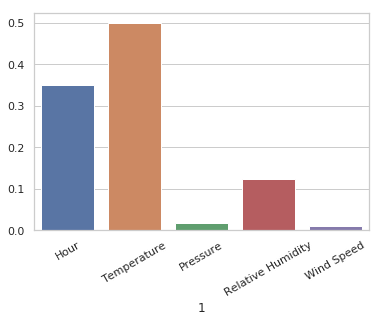

In [71]:
sns.set(style="whitegrid")
print(X.columns)
print(grid_result.best_estimator_.feature_importances_)


sns_plot = sns.barplot(X.columns,grid_result.best_estimator_.feature_importances_)
sns_plot.set_xticklabels(sns_plot.get_xticklabels(), rotation=30)
fig = sns_plot.get_figure()
fig.savefig("../docs/feature_importance_vertical.png",dpi=200,bbox_inches = "tight")

# sns_plot = sns.barplot(grid_result.best_estimator_.feature_importances_, X.columns)
# fig = sns_plot.get_figure()
# fig.savefig("../docs/feature_importance_horizontal.png",dpi=200,bbox_inches = "tight")

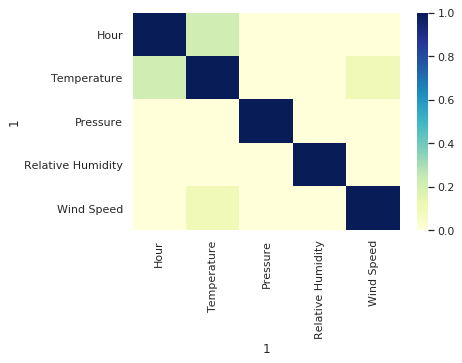

In [66]:
corr_hm = sns.heatmap(X.corr(), 
                xticklabels=X.corr().columns,
                yticklabels=X.corr().columns,vmin=0,vmax=1,cmap="YlGnBu")
plt.show()
# plt.tight_layout()

corr_hm.figure.savefig("../docs/corr_heatmap.png",dpi=200,bbox_inches = "tight")

In [60]:
print("--------------------------------------------------------------------")
print("Best: %f using %s" % (math.sqrt(-grid_result.best_score_), grid_result.best_params_))
print("--------------------------------------------------------------------")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (math.sqrt(-mean), stdev, param))
scores = [math.sqrt(-x) for x in grid_result.cv_results_['mean_test_score']]
scores = np.array(scores).reshape(len(max_depth), len(n_estimators))
%matplotlib notebook
%matplotlib notebook
score = {}
for ind, i in enumerate(max_depth):
    score[i] = scores[ind]

--------------------------------------------------------------------
Best: 72.051383 using {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50}
--------------------------------------------------------------------
122.661073 (6902.886067) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 10}
86.197674 (3751.512773) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 20}
78.106418 (3411.851410) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50}
76.690101 (3321.993854) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}
75.927665 (3254.264527) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 150}
75.573487 (3222.241028) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200}
93.355102 (5065.101087) with: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 10}
76.599780 (3459.423915) with: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 20}
73.417947 (3221.876390) with: {'learning_rate': 0.2, 'max_depth':

In [42]:
import numpy as np
from bokeh.models import Label
from bokeh.layouts import gridplot
from bokeh.plotting import figure, save, output_file

p1 = figure()
p1.grid.grid_line_alpha=0.6
p1.xaxis.axis_label = 'n_estimators'
p1.yaxis.axis_label = 'RSME'

p1.line(n_estimators, score[2] , color='#A6CEE3', legend="max_depth:2")
p1.circle(n_estimators, score[2], color='#A6CEE3', legend="max_depth:2")
p1.line(n_estimators, score[4] , color='#000000', legend="max_depth:4")
p1.circle(n_estimators, score[4], color='#000000', legend="max_depth:4")
p1.line(n_estimators, score[6] , color='#FFFF00', legend="max_depth:6")
p1.circle(n_estimators, score[6], color='#FFFF00', legend="max_depth:6")
p1.line(n_estimators, score[8] , color='#00FF00', legend="max_depth:8")
p1.circle(n_estimators, score[8], color='#00FF00', legend="max_depth:8")
p1.line(n_estimators, score[10] , color='#000080', legend="max_depth:10")
p1.circle(n_estimators, score[10], color='#000080', legend="max_depth:10")

output_file("rsme.html", title="RSME Plots")

save(gridplot([[p1]], plot_width=900, plot_height=600))  # open a browser

'/home/primus/durgeshapi/ensemble/src/rsme.html'